# Landsat/S2 comparison <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule),
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3)
* **Special requirements:** The [DEA Waterbodies shapefile](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/132814).

## Description

Sentinel 2 could be used to improve the cadence of the time series in DEA Waterbodies by adding more observations. But Sentinel 2 is a different satellite to Landsat 5/7/8, and so they have differences in how they observe the Earth's surface. DEA Waterbodies uses Water Observations from Space (WOfS) to identify water on the Australian continent. WOfS is a classification algorithm that runs on Landsat 5, 7, and 8 data, and so we expect that its behaviour will differ if running on Sentinel 2 data. Would this different behaviour be significant provided we already know the maximum extent of the waterbody and only want to improve our cadence? Another big issue is the cloud masking for Sentinel 2, which tends to over-mask. If we are only looking to improve cadence of existing waterbodies, then we might not mind that the cloud masking is problematic, because we can just throw out observations that have cloud masking.  This notebook compares Landsat to Sentinel 2 for shared scenes over water, to see how different a naive implementation of WOfS for Sentinel 2 would affect DEA Waterbodies.

First, we will examine a single waterbody. Then we will examine many waterbodies within an image.

## Getting started

To run this analysis, work through this notebook starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
from pathlib import Path
import warnings

import geopandas as gp
import scipy.stats
import pandas as pd
import os.path
import datacube
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from datacube.virtual import catalog_from_file

import sys

sys.path.insert(1, "../../../Scripts")
from dea_spatialtools import xr_rasterize
from dea_waterbodies import get_waterbody
from dea_datahandling import mostcommon_crs

import fuzzy_wofs

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Analysis parameters

This section lets you set parameters for the analysis.

### Choose a waterbody

Specify the geohash of a waterbody here:

In [2]:
# geohash = 'r3dp84s8n'  # Lake Ginninderra
# geohash = 'r1wjpxgdu'  # Lake Cullen
geohash = "r1czh3f0m"  # Unnamed waterbody in Wallaroo SA
# geohash = 'r1twfjsxz'  # Lake Tyrrell

### Waterbody sample

Choose a bounding box for bulk waterbodies.

In [3]:
# Wee Waa
southwest = (-30.36858, 148.94163)
northeast = (-29.96350, 149.62534)

bulk_ylim, bulk_xlim = zip(southwest, northeast)

And specify a path to the waterbody shapefile:

In [4]:
wbs_path = "DigitalEarthAustraliaWaterbodies.shp"

## Comparing Landsat and Sentinel 2 WOfS for one waterbody

We will start by examining how WOfS behaves on Sentinel 2 data for just one waterbody.

### Find scenes with Landsat and S2

Fetch the waterbody polygon extents:

In [5]:
wb = get_waterbody(geohash)

In [6]:
xlim = wb.total_bounds[::2]
ylim = wb.total_bounds[1::2]

Set up the datacube:

In [7]:
# Set up the datacube to get DEA data.
dc = datacube.Datacube(app="LandsatS2Comparison")

# Some query parameters.
dask_chunks = {"x": 3000, "y": 3000, "time": 1}

Load Sentinel 2 to match Landsat 8. Decide whether or not to resample S2 to match LS8 or vice-versa:

In [8]:
resample_to_ls8 = True

In [9]:
if resample_to_ls8:
    output_crs = mostcommon_crs(
        dc, "ga_ls8c_ard_3", query=dict(x=xlim, y=ylim, crs="EPSG:3577")
    )
    # 25 x 25 matches Landsat WOfS
    resolution = (-25, 25)
else:
    output_crs = mostcommon_crs(
        dc, "s2a_ard_granule", query=dict(x=xlim, y=ylim, crs="EPSG:3577")
    )
    # 10 x 10 matches Sentinel 2
    resolution = (-10, 10)

Build a query for getting S2 and Landsat data:

In [10]:
query = dict(
    x=xlim,
    y=ylim,
    crs="EPSG:3577",
    output_crs=output_crs,
    resampling={"fmask": "nearest", "*": "bilinear"},
    resolution=resolution,
    dask_chunks=dask_chunks,
    group_by="solar_day",
)

Load Sentinel 2:

In [11]:
s2a = dc.load(product="s2a_ard_granule", **query)
s2b = dc.load(product="s2b_ard_granule", **query)

And load Landsat using a virtual product catalogue which combines all observations from Landsat 5, 7, and 8:

In [12]:
catalogue = catalog_from_file("virtual_prod_landsat.yaml")

In [13]:
ls8 = catalogue["ls_nbart"].load(dc, **query)

Then we can get what times were observed for each satellite.

In [14]:
s2b_times = pd.to_datetime(s2b.time.values)
s2a_times = pd.to_datetime(s2a.time.values)
ls8_times = pd.to_datetime(ls8.time.values)

Consider two observations the "same date" if they are within a day of each other.

In [15]:
# Repeat for Sentinel 2A and Sentinel 2B.
ls8_to_s2a_times = {}
for time in ls8_times:
    deltas = time - s2a_times
    minimum = abs(deltas).min()
    if minimum > pd.to_timedelta("1 day"):
        continue

    minimiser = abs(deltas).argmin()
    ls8_to_s2a_times[time] = s2a_times[minimiser]

ls8_to_s2b_times = {}
for time in ls8_times:
    deltas = time - s2b_times
    minimum = abs(deltas).min()
    if minimum > pd.to_timedelta("1 day"):
        continue

    minimiser = abs(deltas).argmin()
    ls8_to_s2b_times[time] = s2b_times[minimiser]

In [16]:
print(
    "Found", len(ls8_to_s2a_times) + len(ls8_to_s2b_times), "co-occurring observations"
)

Found 59 co-occurring observations


Filter out any observations that don't occur at these times.

In [17]:
s2a = s2a.sel(time=list(set(ls8_to_s2a_times.values())))
s2b = s2b.sel(time=list(set(ls8_to_s2b_times.values())))
ls8 = ls8.sel(time=sorted(set(ls8_to_s2a_times.keys()) | set(ls8_to_s2b_times.keys())))

In [18]:
assert len(set(ls8_to_s2a_times.values())) == len(s2a.time)
assert len(set(ls8_to_s2b_times.values())) == len(s2b.time)

Get cloud masks for the observations.

In [19]:
s2a_fmask = (s2a.fmask == 1) | (s2a.fmask == 4) | (s2a.fmask == 5)
s2b_fmask = (s2b.fmask == 1) | (s2b.fmask == 4) | (s2b.fmask == 5)
ls8_fmask = (ls8.fmask == 1) | (ls8.fmask == 4) | (ls8.fmask == 5)

We only care about pixels that overlap the waterbody, so rasterise the waterbody and we can use it for a mask.

In [20]:
wb_raster = xr_rasterize(wb, ls8)

Then and it with the cloud mask so we only include clear pixels that are also within the waterbody:

In [21]:
s2a_mask = s2a_fmask & wb_raster
s2b_mask = s2b_fmask & wb_raster
ls8_mask = ls8_fmask & wb_raster

What rate are pixels within the waterbody masked at?

In [22]:
s2a_pc_clear = s2a_mask.sum(axis=(1, 2)) / wb_raster.sum()
s2b_pc_clear = s2b_mask.sum(axis=(1, 2)) / wb_raster.sum()
ls8_pc_clear = ls8_mask.sum(axis=(1, 2)) / wb_raster.sum()

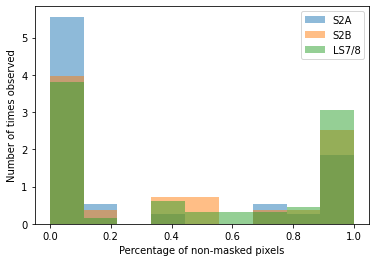

In [23]:
plt.hist(s2a_pc_clear, label="S2A", density=True, alpha=0.5, bins=np.linspace(0, 1, 10))
plt.hist(s2b_pc_clear, label="S2B", density=True, alpha=0.5, bins=np.linspace(0, 1, 10))
plt.hist(
    ls8_pc_clear, label="LS7/8", density=True, alpha=0.5, bins=np.linspace(0, 1, 10)
)
plt.xlabel("Percentage of non-masked pixels")
plt.ylabel("Number of times observed")
plt.legend()

As usual in DEA Waterbodies, throw out observations with <90% clear pixels. **Note that this throws out more observations than necessary because of the resampling to match DEA Waterbodies with LS8 Collection 3., so we will set the threshold to 80% to avoid throwing out too much data.**

In [24]:
s2a = s2a.sel(time=s2a.time[s2a_pc_clear >= 0.8])
s2b = s2b.sel(time=s2b.time[s2b_pc_clear >= 0.8])
ls8 = ls8.sel(time=ls8.time[ls8_pc_clear >= 0.8])

print(len(s2a.time), "Sentinel 2A observations")
print(len(s2b.time), "Sentinel 2B observations")

/env/lib/python3.6/site-packages/pandas/core/arrays/datetimelike.py:559: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = self._data[key]
/env/lib/python3.6/site-packages/xarray/core/indexes.py:117: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  new_index = index[indexer]


8 Sentinel 2A observations
7 Sentinel 2B observations


### Run WOfS on each scene

Now we run WOfS on every observation that has data and examine the outputs.

Convert the datasets into formats that WOfS can use:

In [25]:
s2_bands = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir_1",
    "nbart_swir_2",
    "nbart_swir_3",
]

ls_bands = [
    "blue",
    "green",
    "red",
    "nir",
    "swir1",
    "swir2",
]

In [26]:
s2a_cube = s2a[s2_bands].to_array()
s2b_cube = s2b[s2_bands].to_array()
ls8_cube = ls8[ls_bands].to_array()

Specify whether the outputs should be fuzzy or not:

In [27]:
fuzzy_outputs = True

Run WOfS on each pair of observations and plot Landsat WOfS vs Sentinel 2A WOfS:

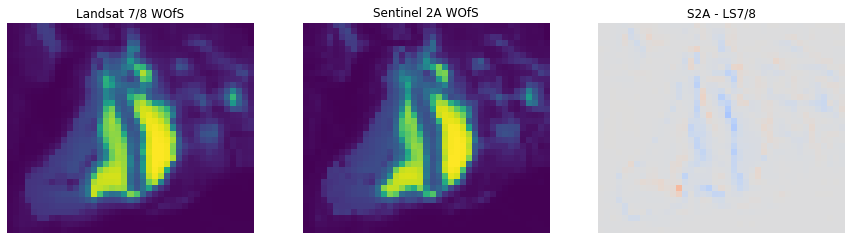

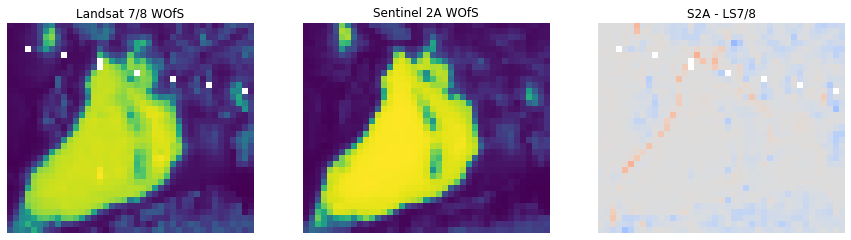

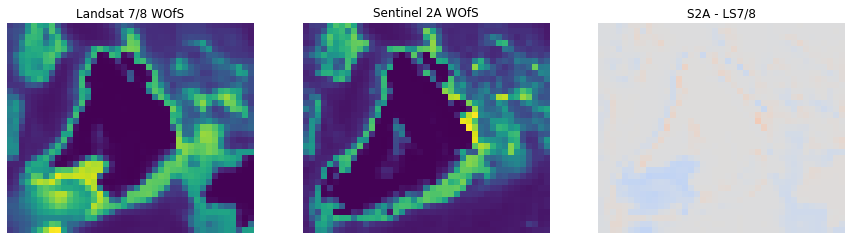

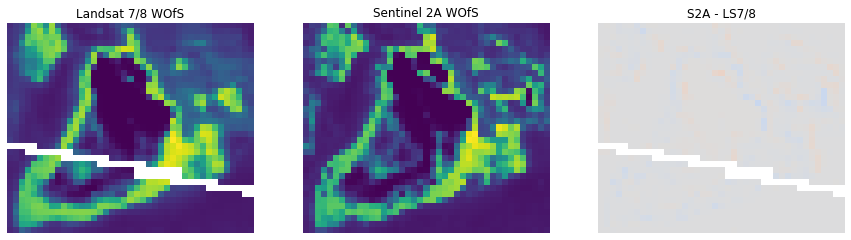

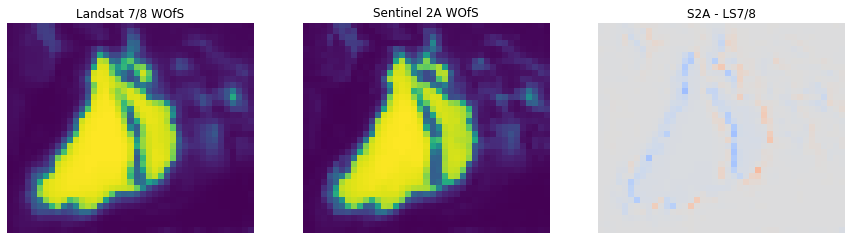

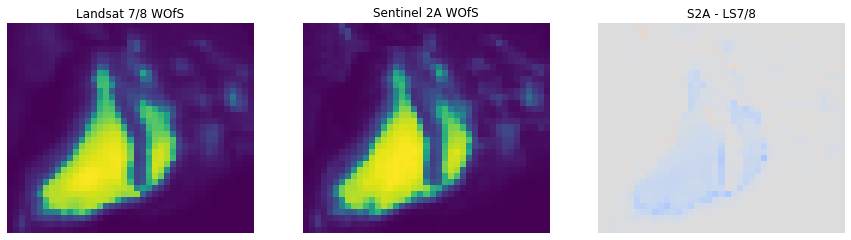

In [28]:
for ls8_time, s2a_time in ls8_to_s2a_times.items():
    try:
        ls8_im = ls8_cube.sel(time=ls8_time)
    except KeyError:
        continue
    try:
        s2a_im = s2a_cube.sel(time=s2a_time)
    except KeyError:
        continue

    if not fuzzy_outputs:
        ls8_wofs = fuzzy_wofs.wofs.predict(ls8_im)
        s2a_wofs = fuzzy_wofs.wofs.predict(s2a_im)
    else:
        ls8_wofs = fuzzy_wofs.wofs.fuzzy_predict(
            ls8_im, fuzzy_wofs.guess_noise(ls8_im.fillna(0))
        )
        s2a_wofs = fuzzy_wofs.wofs.fuzzy_predict(
            s2a_im, fuzzy_wofs.guess_noise(s2a_im.fillna(0))
        )

    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    axs[0].imshow(ls8_wofs, interpolation="nearest")
    axs[1].imshow(s2a_wofs, interpolation="nearest")
    axs[2].imshow(
        ls8_wofs.astype(float) - s2a_wofs.astype(float),
        interpolation="nearest",
        vmin=-1,
        vmax=1,
        cmap="coolwarm_r",
    )
    axs[0].set_title("Landsat 7/8 WOfS")
    axs[0].axis("off")
    axs[1].set_title("Sentinel 2A WOfS")
    axs[1].axis("off")
    axs[2].set_title("S2A - LS7/8")
    axs[2].axis("off")
    plt.show()

Repeat for Sentinel 2B:

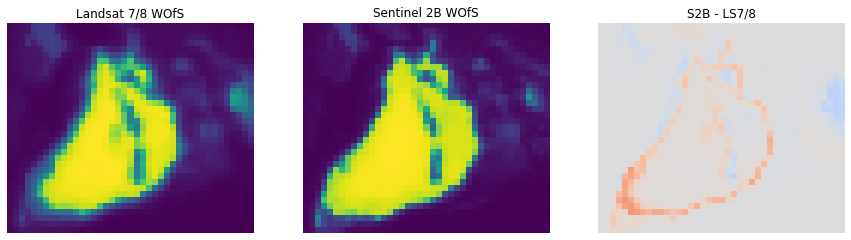

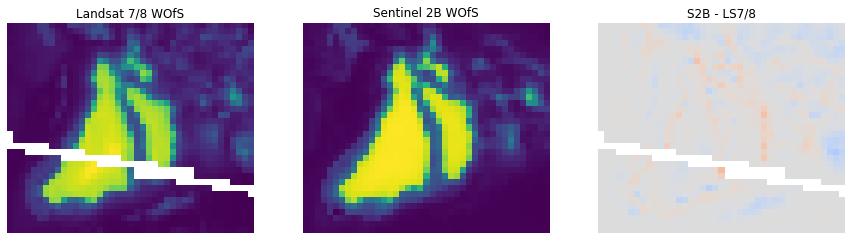

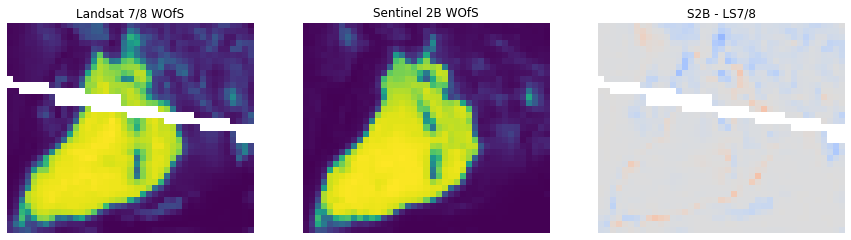

In [29]:
for ls8_time, s2b_time in ls8_to_s2b_times.items():
    try:
        ls8_im = ls8_cube.sel(time=ls8_time)
    except KeyError:
        continue
    try:
        s2b_im = s2b_cube.sel(time=s2b_time)
    except KeyError:
        continue

    if not fuzzy_outputs:
        ls8_wofs = fuzzy_wofs.wofs.predict(ls8_im)
        s2b_wofs = fuzzy_wofs.wofs.predict(s2b_im)
    else:
        ls8_wofs = fuzzy_wofs.wofs.fuzzy_predict(
            ls8_im, fuzzy_wofs.guess_noise(ls8_im.fillna(0))
        )
        s2b_wofs = fuzzy_wofs.wofs.fuzzy_predict(
            s2b_im, fuzzy_wofs.guess_noise(s2b_im.fillna(0))
        )

    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    axs[0].imshow(ls8_wofs, interpolation="nearest")
    axs[1].imshow(s2b_wofs, interpolation="nearest")
    axs[2].imshow(
        ls8_wofs.astype(float) - s2b_wofs.astype(float),
        interpolation="nearest",
        vmin=-1,
        vmax=1,
        cmap="coolwarm_r",
    )
    axs[0].set_title("Landsat 7/8 WOfS")
    axs[0].axis("off")
    axs[1].set_title("Sentinel 2B WOfS")
    axs[1].axis("off")
    axs[2].set_title("S2B - LS7/8")
    axs[2].axis("off")
    plt.show()

## Evaluate many waterbodies

Repeat the above process for many waterbodies so we can examine the bulk statistics.

### Load many waterbodies

Get all waterbodies in the bounding box:

In [30]:
wbs = gp.read_file(wbs_path)

In [31]:
centroids = wbs.to_crs("EPSG:4326").centroid

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [32]:
in_selection = (
    (centroids.x < bulk_xlim[1])
    & (centroids.x > bulk_xlim[0])
    & (centroids.y > bulk_ylim[0])
    & (centroids.y < bulk_ylim[1])
)

In [33]:
selected_wbs = wbs[in_selection]

Define a function that will get the total number of wet pixels for each waterbody. The function is here for maintaining scope rather than enabling reuse:

In [34]:
def get_multisensor_data(
    wbs, query, verbose=False, fuzzy_outputs=False, debug_plots=False, use_ls7=False
):
    # This is the exact same workflow as above.
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=RuntimeWarning)
        xlim = wbs.total_bounds[::2]
        ylim = wbs.total_bounds[1::2]
        if use_ls7:
            query = {**query, "x": xlim, "y": ylim, "resampling": "nearest"}
        else:
            query = {**query, "x": xlim, "y": ylim}
        assert "dask_chunks" in query
        s2a = dc.load(product="s2a_ard_granule", **query)
        if not use_ls7:
            ls8 = dc.load(product="ga_ls8c_ard_3", **query)
        else:
            ls8 = catalogue["ls_nbart"].load(dc, **query)
        s2a_times = pd.to_datetime(s2a.time.values)
        ls8_times = pd.to_datetime(ls8.time.values)

        ls8_to_s2a_times = {}
        for time in ls8_times:
            deltas = time - s2a_times
            minimum = abs(deltas).min()
            if minimum > pd.to_timedelta("1 day"):
                continue

            minimiser = abs(deltas).argmin()
            ls8_to_s2a_times[time] = s2a_times[minimiser]

        if verbose:
            print("Found", len(ls8_to_s2a_times), "co-occurring observations")

        s2a = s2a.sel(time=list(set(ls8_to_s2a_times.values())))
        ls8 = ls8.sel(time=sorted(set(ls8_to_s2a_times.keys())))

        assert len(set(ls8_to_s2a_times.values())) == len(s2a.time)

        s2a_fmask = (s2a.fmask == 1) | (s2a.fmask == 4) | (s2a.fmask == 5)
        if use_ls7:
            ls8_fmask = (ls8.fmask == 1) | (ls8.fmask == 4) | (ls8.fmask == 5)
        else:
            ls8_fmask = (ls8.oa_fmask == 1) | (ls8.oa_fmask == 4) | (ls8.oa_fmask == 5)

        wbs["idx"] = np.arange(1, len(wbs.index) + 1)
        wbs_raster = xr_rasterize(wbs, ls8, attribute_col="idx")

        wb_raster = wbs_raster > 0

        s2a_mask = s2a_fmask & wb_raster
        ls8_mask = ls8_fmask & wb_raster

        s2a_pc_clear = s2a_mask.sum(axis=(1, 2)) / wb_raster.sum()
        ls8_pc_clear = ls8_mask.sum(axis=(1, 2)) / wb_raster.sum()

        s2a = s2a.sel(time=s2a.time[s2a_pc_clear >= 0.8])
        ls8 = ls8.sel(time=ls8.time[ls8_pc_clear >= 0.8])

        if verbose:
            print(len(s2a.time), "Sentinel 2A observations")

        s2a_cube = s2a[s2_bands].to_array()
        if not use_ls7:
            ls8_cube = ls8[
                [
                    "nbart_blue",
                    "nbart_green",
                    "nbart_red",
                    "nbart_nir",
                    "nbart_swir_1",
                    "nbart_swir_2",
                ]
            ].to_array()
        else:
            ls8_cube = ls8[ls_bands].to_array()

        s2a_wofs_all = []
        ls8_times_ok = []
        s2a_times_ok = []
        for ls8_time, s2a_time in tqdm(
            ls8_to_s2a_times.items(), total=len(ls8_to_s2a_times)
        ):
            try:
                ls8_im = ls8_cube.sel(time=ls8_time).fillna(0)
            except KeyError:
                continue
            try:
                s2a_im = s2a_cube.sel(time=s2a_time).fillna(0)
            except KeyError:
                continue
            if verbose:
                print("Processing", ls8_time)

            ls8_im.load()
            s2a_im.load()

            ls8_mask_ = ls8_fmask.sel(time=ls8_time).load()
            s2a_mask_ = s2a_fmask.sel(time=s2a_time).load()

            if not fuzzy_outputs:
                ls8_wofs = fuzzy_wofs.wofs.predict(ls8_im)
                s2a_wofs = fuzzy_wofs.wofs.predict(s2a_im)
            else:
                ls8_wofs = fuzzy_wofs.wofs.fuzzy_predict(
                    ls8_im, fuzzy_wofs.guess_noise(ls8_im)
                )
                s2a_wofs = fuzzy_wofs.wofs.fuzzy_predict(
                    s2a_im, fuzzy_wofs.guess_noise(s2a_im)
                )

            # Count up how many wet pixels there are in each waterbody.
            ts = []
            for i in wbs.idx:
                ts.append(
                    (
                        (s2a_wofs * ((wbs_raster == i) & s2a_mask_)).sum().values,
                        (ls8_wofs * ((wbs_raster == i) & ls8_mask_)).sum().values,
                    )
                )

            s2a_wofs_all.append(ts)
            ls8_times_ok.append(ls8_time)
            s2a_times_ok.append(s2a_time)
        return s2a_wofs_all, ls8_times_ok, s2a_times_ok

Then run the function to get all simultaneous observations:

In [35]:
s2a_comparison, s2a_comp_times_ls8, s2a_comp_times_s2a = get_multisensor_data(
    selected_wbs, query, verbose=True, use_ls7=True
)

Found 113 co-occurring observations


/env/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


15 Sentinel 2A observations


Processing 2016-02-13 23:55:13.698188
Processing 2016-12-29 23:55:30.667411
Processing 2018-03-14 23:56:29.233085
Processing 2018-04-23 23:54:30.603409
Processing 2018-06-02 23:55:12.248080
Processing 2018-07-12 23:54:26.001057
Processing 2018-08-21 23:53:42.944128
Processing 2018-09-30 23:55:01.021243
Processing 2019-01-28 23:49:36.848872
Processing 2019-04-18 23:47:01.245608
Processing 2019-05-28 23:54:58.975169
Processing 2019-08-16 23:55:25.424870



Extract the observed counts:

In [36]:
ls8_counts = []
s2a_counts = []
ls8_percentages = []
s2a_percentages = []

for t, lt, st in zip(tqdm(s2a_comparison), s2a_comp_times_ls8, s2a_comp_times_s2a):
    for w, (i, wb_) in zip(t, selected_wbs.iterrows()):
        s2a_counts.append(w[0])
        ls8_counts.append(w[1])
        s2a_percentages.append(w[0] * 25 ** 2 / wb_.area)
        ls8_percentages.append(w[1] * 25 ** 2 / wb_.area)

r6d7cqkx2 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 16
r6djj9sqh 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 23
r6djn4gx4 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 158
r6dk01n30 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 19
r6dk6n0xq 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 69
r6dk9xdvq 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 142
r6dkcuz20 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 172
r6dkfjdfc 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 206
r6dkk8yg2 2016-12-29 23:55:30.667411 2016-12-29 00:12:12.026000 348
r6d7985tj 2018-03-14 23:56:29.233085 2018-03-14 00:11:01.026000 21
r6d798u06 2018-03-14 23:56:29.233085 2018-03-14 00:11:01.026000 34
r6dhp8pbs 2018-03-14 23:56:29.233085 2018-03-14 00:11:01.026000 345
r6dk24yu2 2018-03-14 23:56:29.233085 2018-03-14 00:11:01.026000 281
r6dm4fd0d 2018-03-14 23:56:29.233085 2018-03-14 00:11:01.026000 1940
r6dm6957j 2018-03-14 23:56:29.233085 2018-03-14 00:11

Plot the Landsat wet pixel counts against the Sentinel 2 wet pixel counts:

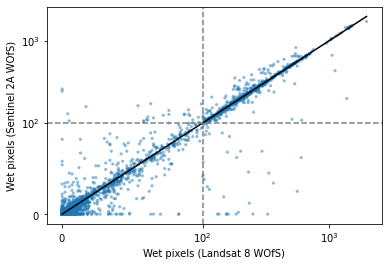

In [37]:
plt.scatter(ls8_counts, s2a_counts, s=10, edgecolor="None", alpha=0.5)
plt.xlabel("Wet pixels (Landsat 8 WOfS)")
plt.ylabel("Wet pixels (Sentinel 2A WOfS)")
plt.xscale("symlog", linthreshx=100)
plt.yscale("symlog", linthreshy=100)
plt.plot([0, max(ls8_counts)], [0, max(ls8_counts)], c="k")
plt.axvline(100, linestyle="--", c="grey")
plt.axhline(100, linestyle="--", c="grey")

Get the correlation statistics:

In [38]:
scipy.stats.linregress(ls8_counts, s2a_counts)

LinregressResult(slope=0.9593282994200077, intercept=0.6636521609643111, rvalue=0.9736140241130118, pvalue=0.0, stderr=0.002643679934307261)

Repeat for the wet pixel percentage instead of the wet pixel count:

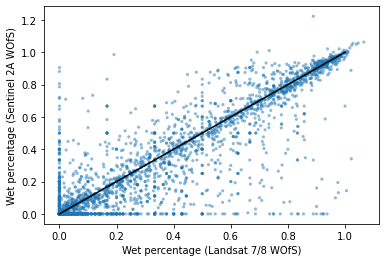

In [39]:
plt.scatter(ls8_percentages, s2a_percentages, s=10, edgecolor="None", alpha=0.5)
plt.xlabel("Wet percentage (Landsat 7/8 WOfS)")
plt.ylabel("Wet percentage (Sentinel 2A WOfS)")
plt.plot([0, 1], [0, 1], c="k")

In [40]:
scipy.stats.linregress(ls8_percentages, s2a_percentages)

LinregressResult(slope=0.90852925642442, intercept=0.004663241996860995, rvalue=0.9231235058677825, pvalue=0.0, stderr=0.00444928502535694)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:**

In [43]:
datacube.__version__

'1.8.3'

## Tags